# Семинар 1: от устройства трансформера до практического применения LLM

## Введение

В этом семинаре мы пройдём путь от устройства декодерного трансформера до прикладного пайплайна, в котором LLM реально приносит пользу: сначала разберём модель по винтикам, а затем применим её для автоматической проверки кода (быстро, контролируемо и без утечек решения).

Главная идея: LLM - не магия, а *конкретный вычислительный граф*, который становится практичным инструментом, когда вы умеете:

1. понимать, что именно происходит внутри слоев (attention, MLP, residual, causal mask);
2. запускать модель в продакшн-режиме: контролировать генерацию, формат диалога и безопасность ответа.

**Структура урока:**

1. **Теория (Build-a-Transformer).** Реализуем GPT-2-like архитектуру по слоям (MLP и masked self-attention), соберем TransformerLayer и полную модель, загрузим официальные веса GPT-2 и проверим корректность простыми тестами.

2. **Практика (Production).** Соберем систему автопроверки решений студентов: быстрый инференс через vLLM на кодовой модели, аккуратный промптинг (instruct-формат, chat templates), управление декодированием и пост-обработка (guardrails), плюс пример альтернативы через облачный API (если нет GPU).


## Часть 1. Собираем GPT-2 с нуля по слоям

**Зачем это делаем?**

В реальных проектах вы почти всегда используете готовые модели (HF / vLLM), но чтобы уверенно работать с ними (скорость, память, KV-cache, шаблоны, промптинг), важно понимать, что именно происходит *под капотом*.

В этой части мы:

* шаг за шагом реализуем блоки **MLP** и **Masked Self-Attention**;
* соберем из них **TransformerLayer**;
* затем соберём целиком **GPT-2-подобную модель**;
* загрузим **официальные веса GPT-2** и проверим корректность через простые тесты (checksum).

> Основа идеи и структуры: [учебный build-a-transformer](https://github.com/yandexdataschool/nlp_course/blob/2025/week05_llm/seminar.ipynb) (Ilya Beletsky). Мы адаптируем код под современный PyTorch и добавляем комментарии.


```text
┌─────────────────────────────────────────────────────────────────────────────┐
│                Самописный GPT-2-like Transformer (Causal LM)               │
└─────────────────────────────────────────────────────────────────────────────┘

                 input_ids (B, T)
                       │
                       ▼
        ┌───────────────────────────┐      ┌───────────────────────────┐
        │ Token Embedding (wte)     │      │ Position Embedding (wpe)  │
        │ E_tok: (B, T, D)          │      │ E_pos: (B, T, D)           │
        └───────────────┬───────────┘      └───────────────┬───────────┘
                        │                                  │
                        └───────────────┬──────────────────┘
                                        ▼
                              X0 = E_tok + E_pos
                                   (B, T, D)
                                        │
                                        ▼
        ┌─────────────────────────────────────────────────────────────────┐
        │                 Transformer block × N (Stack)                   │
        │                                                                 │
        │   ┌───────────────┐            ┌───────────────────────────┐    │
        │   │   LayerNorm   │            │        LayerNorm          │    │
        │   └───────┬───────┘            └──────────┬────────────────┘    │
        │           │                               │                     │
        │           ▼                               ▼                     │
        │  Masked Multi-Head Self-Attention      MLP / FFN                │
        │    (causal mask: only left)        Linear → GeLU → Linear       │
        │           │                               │                     │
        │           ▼                               ▼                     │
        │    + Residual: X = X + Attn          + Residual: X = X + MLP    │
        │                                                                 │
        └─────────────────────────────────────────────────────────────────┘
                                        │
                                        ▼
                              Final LayerNorm (ln_f)
                                   (B, T, D)
                                        │
                                        ▼
                 Logits: (B, T, V) = X @ wte.weightᵀ   (weight tying)
                                        │
                                        ▼
                          next-token distribution at time t
```

### Установка и импорты

In [ ]:
%pip install -q transformers huggingface_hub

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers

### Загружаем веса GPT-2 и подготавливаем state_dict


**Что важно знать про веса**

- В `nn.Linear` веса хранятся в виде матрицы[out_features, in_features].
- В некоторых старых сохранениях/реализациях встречается другой порядок, поэтому иногда нужно транспонировать матрицы.
- В GPT-2 часто есть служебные треугольные маски в state_dict (например, `attn.bias`). В нашей реализации мы их не используем - PyTorch умеет каузальную маску сам (или мы можем сделать её вручную).


In [ ]:
from huggingface_hub import hf_hub_download

# pytorch_model.bin из репозитория gpt2 на HuggingFace
path = hf_hub_download("gpt2", filename="pytorch_model.bin")

# грузим на CPU, чтобы не съедать GPU-память (даже если GPU доступна)
state_dict = torch.load(path, map_location="cpu")

# небольшая подчистка и совместимость:
for key, value in tuple(state_dict.items()):
    # иногда линейные веса ожидаются в другом формате - приводим к формату nn.Linear
    if key.startswith("h.") and key.endswith(".weight") and value.ndim == 2:
        value.transpose_(1, 0)

    # служебные маски внимания нам не нужны (у нас будет is_causal=True)
    if key.startswith("h.") and key.endswith(".attn.bias") and value.ndim == 4:
        state_dict.pop(key)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
print("Пример ключей весов:", list(sorted(state_dict.keys()))[:20])
print("Всего ключей:", len(state_dict))

Пример ключей весов: ['h.0.attn.c_attn.bias', 'h.0.attn.c_attn.weight', 'h.0.attn.c_proj.bias', 'h.0.attn.c_proj.weight', 'h.0.ln_1.bias', 'h.0.ln_1.weight', 'h.0.ln_2.bias', 'h.0.ln_2.weight', 'h.0.mlp.c_fc.bias', 'h.0.mlp.c_fc.weight', 'h.0.mlp.c_proj.bias', 'h.0.mlp.c_proj.weight', 'h.1.attn.c_attn.bias', 'h.1.attn.c_attn.weight', 'h.1.attn.c_proj.bias', 'h.1.attn.c_proj.weight', 'h.1.ln_1.bias', 'h.1.ln_1.weight', 'h.1.ln_2.bias', 'h.1.ln_2.weight']
Всего ключей: 148


In [ ]:
state_dict

OrderedDict([('wte.weight',
              tensor([[-0.1101, -0.0393,  0.0331,  ..., -0.1364,  0.0151,  0.0453],
                      [ 0.0403, -0.0486,  0.0462,  ...,  0.0861,  0.0025,  0.0432],
                      [-0.1275,  0.0479,  0.1841,  ...,  0.0899, -0.1297, -0.0879],
                      ...,
                      [-0.0445, -0.0548,  0.0123,  ...,  0.1044,  0.0978, -0.0695],
                      [ 0.1860,  0.0167,  0.0461,  ..., -0.0963,  0.0785, -0.0225],
                      [ 0.0514, -0.0277,  0.0499,  ...,  0.0070,  0.1552,  0.1207]])),
             ('wpe.weight',
              tensor([[-1.8821e-02, -1.9742e-01,  4.0267e-03,  ..., -4.3044e-02,
                        2.8267e-02,  5.4490e-02],
                      [ 2.3959e-02, -5.3792e-02, -9.4879e-02,  ...,  3.4170e-02,
                        1.0172e-02, -1.5573e-04],
                      [ 4.2161e-03, -8.4764e-02,  5.4515e-02,  ...,  1.9745e-02,
                        1.9325e-02, -2.1424e-02],
                 

### Реализуем MLP-блок (FullyConnected) из GPT-2

**Как устроен MLP в GPT-2**

На входе `x: [batch, seq, dim]`. Дальше:

1. линейный слой `dim → 4*dim`
2. активация GeLU (в GPT-2 используется слегка кастомная формула)
3. линейный слой `4*dim → dim`

> Важно: пока без residual и layernorm - их добавим на уровне TransformerLayer.

In [ ]:
# Реализация GeLU и MLP

class GeLUThatWasUsedInGPT2(nn.Module):
    """
    Та самая версия GeLU, которая использовалась в GPT-2:
    gelu(x) = 0.5 * x * (1 + tanh( sqrt(2/pi) * (x + 0.044715 x^3) ))
    """
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * x ** 3)))

class FullyConnected(nn.Module):
    """
    MLP-блок GPT-2 (без residual и layernorm):
    x -> Linear(dim, 4*dim) -> GeLU -> Linear(4*dim, dim)
    """
    def __init__(self, dim: int):
        super().__init__()
        self.c_fc = nn.Linear(dim, 4 * dim)
        self.gelu = GeLUThatWasUsedInGPT2()
        self.c_proj = nn.Linear(4 * dim, dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [batch_size, seq_length, dim]
        x = self.c_fc(x) # [B, S, 4D]
        x = self.gelu(x) # [B, S, 4D]
        x = self.c_proj(x) # [B, S, D]
        return x

In [ ]:
# проверяем MLP на весах GPT-2

mlp = FullyConnected(dim=768)
mlp.load_state_dict({
    "c_fc.weight":  state_dict["h.0.mlp.c_fc.weight"],
    "c_fc.bias":    state_dict["h.0.mlp.c_fc.bias"],
    "c_proj.weight": state_dict["h.0.mlp.c_proj.weight"],
    "c_proj.bias":   state_dict["h.0.mlp.c_proj.bias"],
})

torch.manual_seed(1337)
x = torch.randn(1, 2, 768)  # [batch, seq, dim]

checksum = torch.sum(mlp(x) * x)

In [ ]:
# численная сверка с эталоном
assert abs(checksum.item() - 1282.3315) < 0.1, "MLP: outputs do not match reference"

# MLP не зависит от порядка токенов (перестановка токенов -> перестановка выходов)
assert torch.allclose(mlp(x[:, (1, 0), :])[:, (1, 0), :], mlp(x)), "MLP должен быть permutation-invariant"

print("MLP: похоже, всё корректно - а мы молодцы!")

MLP: похоже, всё корректно - а мы молодцы!


### Реализуем Masked Self-Attention (каузальное внимание)

**Что такое masked/causal attention?**

GPT-2 генерирует текст слева направо. Значит, токен на позиции *t* имеет право смотреть только на позиции `<= t` (и на себя).

Технически:

* мы строим Q, K, V
* считаем `Attention(Q,K,V) = softmax(QK^T / sqrt(dk) + mask) V`
* маска делает так, чтобы веса на будущие позиции стали `-inf` до softmax.

**Реализация MaskedSelfAttention**

> Примечание. Тут есть цикл по головам и используется `F.scaled_dot_product_attention`.


In [ ]:
class MaskedSelfAttention(nn.Module):
    """
    Masked (causal) self-attention GPT-2:
    - c_attn: одним линейным слоем получаем QKV размера 3*dim
    - режем на q,k,v
    - считаем внимание по головам
    - склеиваем головы и делаем выходную проекцию c_proj
    """
    def __init__(self, dim: int, num_heads: int):
        super().__init__()
        assert dim % num_heads == 0, "dim должен делиться на num_heads"
        self.c_attn = nn.Linear(dim, dim * 3) # QKV вместе
        self.c_proj = nn.Linear(dim, dim) # выходная проекция

        self.dim = dim
        self.num_heads = num_heads
        self.head_size = dim // num_heads

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, S, D]
        qkv = self.c_attn(x) # [B, S, 3D]
        q, k, v = qkv.split(self.dim, dim=-1)

        assert q.shape == k.shape == v.shape == x.shape, "q, k, v должны иметь ту же форму, что и x"

        head_outputs = []
        for head_index in range(self.num_heads):
            start = head_index * self.head_size
            end = (head_index + 1) * self.head_size

            head_q = q[..., start:end]  # [B, S, H]
            head_k = k[..., start:end]  # [B, S, H]
            head_v = v[..., start:end]  # [B, S, H]

            # scaled_dot_product_attention ожидает query/key/value,
            # а дальше сам применит causal mask, если is_causal=True.
            head_out = F.scaled_dot_product_attention(
                head_q, head_k, head_v,
                attn_mask=None,
                dropout_p=0.0,
                is_causal=True
            )  # [B, S, H]

            head_outputs.append(head_out)

        combined = torch.cat(head_outputs, dim=-1) # [B, S, D]
        return self.c_proj(combined) # [B, S, D]

In [ ]:
attn = MaskedSelfAttention(dim=768, num_heads=12)
attn.load_state_dict({
    "c_attn.weight": state_dict["h.0.attn.c_attn.weight"],
    "c_attn.bias":   state_dict["h.0.attn.c_attn.bias"],
    "c_proj.weight": state_dict["h.0.attn.c_proj.weight"],
    "c_proj.bias":   state_dict["h.0.attn.c_proj.bias"],
})

torch.manual_seed(1337)
x = torch.randn(1, 10, 768) # [B, S, D]

checksum = torch.sum(attn(x) * x)

In [ ]:
assert abs(checksum.item() - 2703.6772) < 0.1, "Attention: outputs do not match reference"

# masked attention НЕ permutation-invariant: порядок токенов важен
assert not torch.allclose(
    attn(x[:, (1, 0), :])[:, (1, 0), :],
    attn(x[:, (0, 1), :])
), "Masked attention не должен быть permutation-invariant"

print("Attention: работает - а мы с вами солнышки!")

Attention: работает - а мы с вами солнышки!


#### Улучшение: векторизованное внимание без циклов и без SDPA

Эта часть полезна как - куда двигаться дальше: всё параллельно, без Python-циклов.
Она ближе к тому, что требуется для скорост.


In [ ]:
class MaskedSelfAttentionVectorized(nn.Module):
    """
    Векторизованная версия:
    - без циклов по головам
    - без F.scaled_dot_product_attention
    """
    def __init__(self, dim: int, num_heads: int):
        super().__init__()
        assert dim % num_heads == 0
        self.c_attn = nn.Linear(dim, dim * 3)
        self.c_proj = nn.Linear(dim, dim)
        self.dim = dim
        self.num_heads = num_heads
        self.head_size = dim // num_heads

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, S, D]
        B, S, D = x.shape
        qkv = self.c_attn(x) # [B, S, 3D]
        q, k, v = qkv.split(D, dim=-1) # [B, S, D] каждый

        # -> [B, H, S, Hd]
        q = q.view(B, S, self.num_heads, self.head_size).transpose(1, 2)
        k = k.view(B, S, self.num_heads, self.head_size).transpose(1, 2)
        v = v.view(B, S, self.num_heads, self.head_size).transpose(1, 2)

        # scores: [B, H, S, S]
        scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_size)

        # causal mask: разрешаем только j <= i
        causal = torch.tril(torch.ones(S, S, device=x.device, dtype=torch.bool))
        scores = scores.masked_fill(~causal, float("-inf"))

        attn = torch.softmax(scores, dim=-1) # [B, H, S, S]
        out = attn @ v # [B, H, S, Hd]

        # back to [B, S, D]
        out = out.transpose(1, 2).contiguous().view(B, S, D)
        return self.c_proj(out)

### Собираем TransformerLayer (Pre-Norm + Residual)

В GPT-2 используется схема:

1. `x = x + Attention(LN(x))`
2. `x = x + MLP(LN(x))`

То есть:

* LayerNorm перед блоком (pre-norm),
* residual вокруг блока.

In [ ]:
class TransformerLayer(nn.Module):
    def __init__(self, dim: int, num_heads: int):
        super().__init__()
        self.ln_1 = nn.LayerNorm(dim)
        self.attn = MaskedSelfAttention(dim, num_heads)
        self.ln_2 = nn.LayerNorm(dim)
        self.mlp = FullyConnected(dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Pre-Norm + residual
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

In [ ]:
# Проверяем один слой на весах GPT-2

layer = TransformerLayer(dim=768, num_heads=12)

# берем веса, например, из 10-го блока GPT-2: h.10.*
layer.load_state_dict({k[5:]: v for k, v in state_dict.items() if k.startswith("h.10.")})

# x возьмем тот же, что выше: [1, 10, 768]
checksum = torch.sum(layer(x) * x).item()
assert abs(checksum - 9874.7383) < 0.1

print("TransformerLayer: ок - а мы великолепны!")

TransformerLayer: ок - а мы великолепны!


### Собираем GPT-2 целиком

Архитектура

- `wte`: token embeddings
- `wpe`: position embeddings
- `h`: последовательность TransformerLayer (12 слоёв)
- `ln_f`: финальная layernorm
- логиты считаем через весовую матрицу эмбеддингов (weight tying):
`logits = hidden @ wte.weight.T`


In [ ]:
class GPT2(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        dim: int,
        num_heads: int,
        num_layers: int,
        max_position_embeddings: int = 1024
    ):
        super().__init__()
        self.wte = nn.Embedding(vocab_size, dim) # token embeddings
        self.wpe = nn.Embedding(max_position_embeddings, dim) # position embeddings
        self.ln_f = nn.LayerNorm(dim)

        self.h = nn.Sequential(*(TransformerLayer(dim, num_heads) for _ in range(num_layers)))

    def forward(self, input_ids: torch.Tensor) -> torch.Tensor:
        # input_ids: [B, S] (int64)
        B, S = input_ids.shape
        position_ids = torch.arange(S, device=input_ids.device).unsqueeze(0) # [1, S]

        token_emb = self.wte(input_ids) # [B, S, D]
        pos_emb = self.wpe(position_ids) # [1, S, D]
        x = token_emb + pos_emb # [B, S, D]

        x = self.h(x) # [B, S, D]
        x = self.ln_f(x) # [B, S, D]

        logits = x @ self.wte.weight.T # [B, S, vocab]
        return logits

In [ ]:
# загружаем веса и делаем короткий sanity-check
tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2", add_prefix_space=True)

model = GPT2(vocab_size=50257, dim=768, num_heads=12, num_layers=12)
model.load_state_dict(state_dict)
model.eval()

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

GPT2(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (h): Sequential(
    (0): TransformerLayer(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): MaskedSelfAttention(
        (c_attn): Linear(in_features=768, out_features=2304, bias=True)
        (c_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): FullyConnected(
        (c_fc): Linear(in_features=768, out_features=3072, bias=True)
        (gelu): GeLUThatWasUsedInGPT2()
        (c_proj): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
    (1): TransformerLayer(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): MaskedSelfAttention(
        (c_attn): Linear(in_features=768, out_features=2304, bias=True)
        (c_proj): Linear(in_features=768, out_features=768, bias=True)
   

In [ ]:
# маленькая проверка: предскажем следующий токен после "A quick"
input_ids = tokenizer("A problem", return_tensors="pt")["input_ids"]
with torch.no_grad():
    logits = model(input_ids)

most_likely_token_id = logits[:, -1].argmax().item()
print("Следующий токен (greedy):", tokenizer.decode([most_likely_token_id]))

RuntimeError: Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)

In [ ]:
input_ids

tensor([[ 317, 2068]])

In [ ]:
logits

tensor([[[-32.5711, -32.0801, -34.6744,  ..., -39.6079, -38.6309, -32.1919],
         [-88.6494, -87.2060, -91.3537,  ..., -96.4111, -93.7631, -89.4194]]])

In [ ]:
most_likely_token_id

804

### Генерация текста: контроль, воспроизводимость, безопасность по длине

In [ ]:
@torch.no_grad()
def generate_text(
    model: nn.Module,
    tokenizer,
    prompt: str,
    max_new_tokens: int = 80,
    temperature: float = 0.9,
    top_k: int | None = 50,
    top_p: float | None = 0.95,
    seed: int = 42
) -> str:
    """
    Генерация продолжения текста для нашей самописной GPT-2.

    temperature=0.0 можно трактовать как greedy (но ниже мы делаем отдельную ветку).
    top_k/top_p можно отключать, передав None.
    """

    model.eval()
    torch.manual_seed(seed)

    input_ids = tokenizer(prompt, return_tensors="pt")["input_ids"]

    max_ctx = model.wpe.num_embeddings # 1024 для gpt2
    for _ in range(max_new_tokens):
        # если контекст уперся в максимум позиционных эмбеддингов - останавливаемся
        if input_ids.shape[1] >= max_ctx:
            break

        logits = model(input_ids)[:, -1, :] # [B, vocab]

        # Greedy режим
        if temperature == 0.0:
            next_id = torch.argmax(logits, dim=-1, keepdim=True)
        else:
            # Temperature scaling
            logits = logits / max(temperature, 1e-8)

            # Top-k фильтрация
            if top_k is not None:
                v, _ = torch.topk(logits, top_k)
                logits = logits.masked_fill(logits < v[:, [-1]], float("-inf"))

            probs = torch.softmax(logits, dim=-1)

            # Top-p (nucleus) фильтрация
            if top_p is not None:
                sorted_probs, sorted_ix = torch.sort(probs, descending=True)
                cum = torch.cumsum(sorted_probs, dim=-1)

                cutoff = cum > top_p
                cutoff[..., 0] = False # первый токен всегда оставим
                sorted_probs = sorted_probs.masked_fill(cutoff, 0.0)
                sorted_probs = sorted_probs / sorted_probs.sum(dim=-1, keepdim=True)

                sampled_pos = torch.multinomial(sorted_probs, 1) # позиция в отсортированном списке
                next_id = sorted_ix.gather(-1, sampled_pos) # реальный token_id
            else:
                next_id = torch.multinomial(probs, 1)

        input_ids = torch.cat([input_ids, next_id], dim=-1)

        if next_id.item() == tokenizer.eos_token_id:
            break

    return tokenizer.decode(input_ids[0].tolist())

In [ ]:
prompt = "I used to think intelligence was easy to define, until"
print(generate_text(model, tokenizer, prompt, max_new_tokens=80, temperature=0.9, top_k=50, top_p=0.95, seed=123))

 I used to think intelligence was easy to define, until you realized that it's hard to be objective. I think I've been doing it for a long time, and it's not easy to talk a lot. The best I can tell you is that it's something that happens to you, and it's not just a bad thing. It's a good thing. That's what I try to communicate to myself, but it's hard to think about


In [ ]:
prompt = "When the model failed, we did not blame the data. Instead,"
print(generate_text(model, tokenizer, prompt, max_new_tokens=80, temperature=0.9, top_k=50, top_p=0.95, seed=123))

 When the model failed, we did not blame the data. Instead, the data was blamed on the model's own failure to perform properly, which was ultimately the reason why we failed to test the Model.

To help you make better choices about what data to use in your analytics, let's look at two popular data models, the one that we tested using the Model, and the one that we only tested using the data model that we had previously made.



### То же самое через HuggingFace transformers

Для сравнения: HF уже реализует всё оптимально и удобно.

> Важно: у GPT-2 нет отдельного `pad_token`, поэтому обычно ставят `pad_token_id = eos_token_id`, чтобы убрать предупреждения.


In [ ]:
tokenizer_hf = transformers.AutoTokenizer.from_pretrained("gpt2", add_prefix_space=True)
model_hf = transformers.AutoModelForCausalLM.from_pretrained("gpt2")
model_hf.eval()

prompt = "I used to think intelligence was easy to define, until"

inputs = tokenizer_hf(prompt, return_tensors="pt")

out = model_hf.generate(
    **inputs,
    do_sample=True,
    max_new_tokens=80,
    temperature=0.9,
    top_k=50,
    top_p=0.95,
    pad_token_id=tokenizer_hf.eos_token_id,
)

In [ ]:
print(tokenizer_hf.decode(out[0].tolist()))

 I used to think intelligence was easy to define, until I finally became convinced it was true. Then I started seeing other people get involved with it. It's great, too! There's a whole lot more to this than simply knowing your enemy; people do it all the time.

The way you look at it, it's about having a vision and a purpose for your actions. You have to be willing to be part of that vision and


### Мини-итог части

* Мы восстановили ключевые блоки GPT-2 и убедились, что они совпадают с эталоном по весам.
* Теперь у нас есть правильная ментальная модель: эмбеддинги -> transformer layers -> logits.
* Дальше (в частях 2–3) будет легче понять:

  * зачем vLLM оптимизирует KV-cache,
  * почему chat templates важны,
  * как стратегии декодирования управляют поведением модели.

## Часть 2. Практическая реализация. Автопроверка кода (DeepSeek + vLLM)

В этой части мы решаем задачу: есть тысячи решений студентов. Нужно автоматически дать краткий комментарий по ошибке, если она есть, но не давать готового решения.

### Импорт библиотек и настройка окружения

Для начала установим и импортируем необходимые инструменты. Нам понадобятся:

* `vllm`: библиотека для высокопроизводительного запуска LLM.
* `transformers`: для токенизации и работы с BERT (эмбеддинги).
* `pandas`: для работы с таблицами данных.
* `cleantext`, `better_profanity`: для очистки текста от мусора и мата.

In [ ]:
!pip install flash_attn vllm cleantext better_profanity

In [ ]:
# Основные библиотеки
import os
import io
import json
import ast # парсинг и анализ синтаксических деревьев Python-выражений (например, безопасный eval)
import re
import time
import tempfile
import subprocess   # выполнение внешних процессов из Python
import requests     # HTTP-запросы
import random

import pandas as pd
import torch # PyTorch
from transformers import BertModel, BertTokenizer
from transformers import AutoTokenizer

# vLLM — библиотека для ускоренного инференса LLM (Large Language Models)
from vllm import LLM, SamplingParams

from typing import Optional
from collections import Counter
from multiprocessing import Process, Queue # параллельные процессы и очереди между ними
from tqdm import tqdm

# библиотеки для очистки и фильтрации текста
from cleantext import clean           # очистка текста от мусора, символов, HTML и т.п.
from better_profanity import profanity  # детекция и цензурирование нецензурной лексики

### Загрузка данных

Предполагается, что у нас есть три файла: сами задачи, решения студентов и результаты тестов (ошибки линтера).

In [ ]:
solutions = pd.read_excel('solutions.xlsx')
tasks = pd.read_excel('tasks.xlsx')
tests = pd.read_excel('tests.xlsx')
tests_with_errors = pd.read_csv('test_solutions_with_flake8.csv')

In [ ]:
# Объединяем таблицы, чтобы в одной строке было и решение студента, и условие задачи, и ошибка

solutions = tests_with_errors.merge(
    tasks[['id', 'description', 'author_solution']],
    left_on='task_id',
    right_on='id',
    how='left',
    suffixes=('', '_task')
)

In [ ]:
solutions

,Unnamed: 0,id,task_id,student_solution,author_comment,author_comment_embedding,message,line_number,line,id_task,description,author_solution
0,0,0,0,discount = float(input())\nmoney = int(input(...,Ваше предсказание,NaN,NaN,NaN,NaN,0,"Реализуйте программу, которая напечатает стоим...",discount = float(input())\nmoney = int(input(...
1,1,1,0,discount = float(input())\nmoney = int(input(...,Ваше предсказание,NaN,SyntaxError: unterminated f-string literal (de...,6.0,NaN,0,"Реализуйте программу, которая напечатает стоим...",discount = float(input())\nmoney = int(input(...
2,2,2,0,discount = float(input())\nmoney = int(input(...,Ваше предсказание,NaN,SyntaxError: unterminated string literal (dete...,6.0,NaN,0,"Реализуйте программу, которая напечатает стоим...",discount = float(input())\nmoney = int(input(...
3,3,3,0,discount = float(input())\nmoney = int(input(...,Ваше предсказание,NaN,NaN,NaN,NaN,0,"Реализуйте программу, которая напечатает стоим...",discount = float(input())\nmoney = int(input(...
4,4,4,0,discount = float(input())\nmoney = int(input(...,Ваше предсказание,NaN,NaN,NaN,NaN,0,"Реализуйте программу, которая напечатает стоим...",discount = float(input())\nmoney = int(input(...
...,...,...,...,...,...,...,...,...,...,...,...,...
320,320,725,46,def success(data):\n \n wins = 0\n mo...,Ваше предсказание,NaN,NaN,NaN,NaN,46,"Напишите функцию, определяющую успешна студия ...",def success(data):\n \n wins = 0\n mo...
321,321,726,46,def success(data):\n \n wins = 0\n mo...,Ваше предсказание,NaN,NaN,NaN,NaN,46,"Напишите функцию, определяющую успешна студия ...",def success(data):\n \n wins = 0\n mo...
322,322,727,46,def success(data):\n \n wins = 0\n mo...,Ваше предсказание,NaN,NaN,NaN,NaN,46,"Напишите функцию, определяющую успешна студия ...",def success(data):\n \n wins = 0\n mo...
323,323,728,46,def success(data):\n \n wins = 0\n mo...,Ваше предсказание,NaN,NaN,NaN,NaN,46,"Напишите функцию, определяющую успешна студия ...",def success(data):\n \n wins = 0\n mo...


### Инициализация модели (vLLM)

Мы используем `DeepSeek-Coder-V2-Lite-Instruct`. Это модель, специально обученная понимать и писать код.

> `vLLM` значительно быстрее стандартного `HuggingFace transformers` благодаря оптимизированному ядру CUDA и особому механизму внимания.


### Теоретическая справка

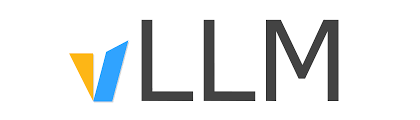

**В чем проблема стандартного подхода (HuggingFace PyTorch)?**


Память в PyTorch (и вообще в CUDA) обычно выделяется непрерывными блоками. Но мы заранее не знаем, какой длины будет ответ модели - 5 слов или 500.

* **Результат.** Система резервирует огромный кусок памяти "на всякий случай" (например, под максимальную длину 2048 токенов).
* **Реальность.** Если ответ короткий, 90% этой зарезервированной памяти пустует. Другие запросы не могут её использовать, потому что она "занята".

Это *фрагментация памяти*. Представьте, что в ресторане за каждый столик на 10 человек сажают только одного гостя. Ресторан вроде бы полон, а людей мало.

**Решение: PagedAttention (Магия vLLM)**

Создатели vLLM (исследователи из UC Berkeley) посмотрели на эту проблему и поняли: операционные системы решили её 40 лет назад.

В компьютере, когда вы запускаете программу, ОС не выделяет ей один сплошной кусок физической RAM. Она разбивает данные на маленькие кусочки - *страницы (pages)* - и распихивает их в любые свободные места в памяти.

**vLLM делает то же самое для LLM:**

1. Она разбивает KV Cache на блоки (например, по 16 токенов).
2. Эти блоки могут лежать в памяти видеокарты где угодно, не обязательно подряд.
3. Специальный алгоритм (PagedAttention) умеет мгновенно собирать информацию из этих разбросанных блоков.

Итог. Фрагментация памяти падает почти до 0%. В "ресторан" (GPU) теперь можно посадить в 2-4 раза больше "гостей" (запросов пользователей) одновременно.

**Вторая фишка: Continuous Batching (Непрерывный батчинг)**

Представьте, что вы обрабатываете 3 запроса одновременно (батч = 3):

1. Запрос А: "Привет" (короткий).
2. Запрос Б: "Напиши эссе" (длинный).
3. Запрос В: "Код на Python" (средний).

В старых системах весь батч ждет самого медленного. Запрос А давно готов, но видеокарта не может его отдать и взять новый, пока не закончит Запрос Б.

**В vLLM.** Как только Запрос А завершился, vLLM сразу же на его место ставит новый Запрос Г, не дожидаясь окончания длинного Запроса Б. Видеокарта никогда не простаивает.

> *Почему это важно для нас?*

1. Пропускная способность (Throughput). vLLM обрабатывает в 2-24 раза больше токенов в секунду, чем стандартный HuggingFace. Это критично, если вы проверяете тысячи студенческих работ.
2. Экономия денег. Вы можете запустить ту же модель на меньшем количестве видеокарт.
3. Простота. vLLM поддерживает почти все популярные модели (Llama, Mistral, Qwen, DeepSeek) "из коробки".

In [ ]:
# Сравнение в коде

# Обычный HuggingFace (медленно, много памяти)

model = AutoModelForCausalLM.from_pretrained(...)
# Если придет 10 запросов, память может переполниться из-за фрагментации

# vLLM (быстро, оптимально)
# PagedAttention работает автоматически

from vllm import LLM
llm = LLM(model="deepseek-ai/...", swap_space=16)

# swap_space позволяет сбрасывать часть данных в RAM, если GPU переполнится,
# чтобы не упасть с ошибкой OOM

### Поехали дальше

In [ ]:
max_model_len, tp_size = 8192, 1 # 8192 токена контекста. tp_size=1 -> без tensor-parallel на несколько GPU
model_name = "deepseek-ai/DeepSeek-Coder-V2-Lite-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)

llm = LLM(
    model=model_name,                   # та же строка, что и выше
    tensor_parallel_size=tp_size,       # параллелим веса по tp_size устройствам
    max_model_len=max_model_len,        # ограничение длины входа + генерации
    trust_remote_code=True,             # разрешаем выполнять кастомный __init__.py из репозитория модели
    enforce_eager=True                  # отключаем torch.compile / lazy-mode -> проще отладка, меньше RAM-пик
)

sampling_params = SamplingParams(
    temperature=0.0,                    # 0.0 -> детерминированный greedy (всегда берём токен с макс. prob)
    max_tokens=256,                     # ограничиваем длину выдачи, чтобы не выйти за пределы
    stop_token_ids=[tokenizer.eos_token_id]  # при встрече <eos> модель останавливается
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


INFO 10-19 17:46:29 config.py:107] Replacing legacy 'type' key with 'rope_type'
WARNING 10-19 17:46:38 config.py:395] To see benefits of async output processing, enable CUDA graph. Since, enforce-eager is enabled, async output processor cannot be used
INFO 10-19 17:46:38 llm_engine.py:237] Initializing an LLM engine (v0.6.3.post1) with config: model='deepseek-ai/DeepSeek-Coder-V2-Lite-Instruct', speculative_config=None, tokenizer='deepseek-ai/DeepSeek-Coder-V2-Lite-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=True, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outli

model-00003-of-000004.safetensors:   0%|          | 0.00/8.59G [00:00<?, ?B/s]

model-00001-of-000004.safetensors:   0%|          | 0.00/8.59G [00:00<?, ?B/s]

model-00004-of-000004.safetensors:   0%|          | 0.00/5.64G [00:00<?, ?B/s]

model-00002-of-000004.safetensors:   0%|          | 0.00/8.59G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]


INFO 10-19 17:48:25 model_runner.py:1067] Loading model weights took 29.3010 GB
WARNING 10-19 17:48:26 fused_moe.py:323] Using default MoE config. Performance might be sub-optimal! Config file not found at /usr/local/lib/python3.10/dist-packages/vllm/model_executor/layers/fused_moe/configs/E=64,N=1408,device_name=NVIDIA_A100-SXM4-40GB.json
INFO 10-19 17:48:29 gpu_executor.py:122] # GPU blocks: 674, # CPU blocks: 606
INFO 10-19 17:48:29 gpu_executor.py:126] Maximum concurrency for 8192 tokens per request: 1.32x


Вспомним, что под капотом это все еще просто генеративная модель, которая предсказывает вероятности следующих токенов. Что делать с этими вероятностями дальше - можно определить с помощью стратегии генерации.

| Стратегия | Описание | Плюсы и минусы |
| --- | --- | --- |
| Greedy Search | Выбирает слово с наивысшей вероятностью как следующее слово в последовательности. | Плюсы: Простота и скорость.<br> Минусы: Может привести к повторяющемуся и несвязному тексту. |
| Семплинг с температурой | Добавляет случайность в выбор слова. Большая температура приводит к большей случайности. | Плюсы: Позволяет исследовать и получать разнообразный результат.<br> Минусы: Высокие температуры могут привести к бессмысленным результатам. |
| Семплинг по ядру (Top-p семплинг) | Выбирает следующее слово из усеченного словаря, "ядра" слов, которые имеют суммарную вероятность, превышающую предустановленный порог (p). | Плюсы: Обеспечивает баланс между разнообразием и качеством.<br> Минусы: Настройка оптимального 'p' может быть затруднительна. |
| Beam Search | Исследует множество гипотез (последовательностей слов) на каждом шаге и сохраняет 'k' наиболее вероятных, где 'k' - ширина луча. | Плюсы: Дает более надежные результаты, чем жадный поиск.<br> Минусы: Может страдать от нехватки разнообразия и приводить к общим ответам. |
| Top-k семплинг | Случайным образом выбирает следующее слово из 'k' слов с самыми высокими вероятностями. | Плюсы: Вводит случайность, увеличивая разнообразие результатов.<br> Минусы: Случайный выбор иногда может привести к менее связному тексту. |
| Нормализация длины | Предотвращает предпочтение модели более коротких последовательностей за счет деления логарифмированных вероятностей на длину последовательности, возведенную в некоторую степень. | Плюсы: Делает более длинные и потенциально более информативные последовательности более вероятными.<br> Минусы: Настройка фактора нормализации может быть сложной. |
| Стохастический Beam Search | Вводит случайность в процесс выбора 'k' гипотез в поиске пучком. | Плюсы: Увеличивает разнообразие в сгенерированном тексте.<br> Минусы: Баланс между разнообразием и качеством может быть сложно управлять. |
| Декодирование с минимальным риском Байеса (MBR) | Выбирает гипотезу (из многих), которая минимизирует ожидаемую потерю для функции потерь. | Плюсы: Оптимизирует результат в соответствии с определенной функцией потерь.<br> Минусы: Вычислительно более сложно и требует хорошо подобранную функциию потерь. |

Референсы:
- [Статья о стратегиях генерации на Huggingface](https://huggingface.co/docs/transformers/generation_strategies)

Здесь мы используем **Prompt Engineering**. Мы задаем модели роль (System Prompt) и передаем данные (User Prompt).


In [ ]:
# Функция для генерации комментария
def generate_comment(task_description, student_solution, synt_errors):

    """
    Использует DeepSeek-Coder-V2-Lite-Instruct для краткого фидбэка к решению студента.
    Возвращает одну фразу — указание на синтаксическую/логическую ошибку.

    Args:
        task_description : формулировка задачи
        student_solution : код ученика (может содержать ошибки)
        synt_errors      : сообщение Python-интерпретатора, если код даже не запускается
    """

    # system-prompt: задаём стиль и правила ответа
    system_message = '''
    Ты - профессиональный программист и учитель.
    Я пришлю тебе условие задачи, верное решение и мое решение с ошибками.
    Дай крайне короткий ответ в одном предложении об ошибке в решении.
    Ошибки могут быть синтаксические и логические.
    Объясни ошибку через смысл задания. Ни в коем случае не ссылайся на реализацию в верном решении.
    Ни в коем случае не присылай исправленный код решения.
    Используй следующие фразы: "ваш код", "выполняет условия", "попробуйте изменить", "условия задания", "некорректно выполняет", "скорректировать ошибку" или задавай наводящие вопросы, если нужно обратить внимание на ошибку в коде.
    '''

    # user-prompt: содержимое конкретного задания
    user_message = f'''
    Условие задачи:
    {task_description}

    Мое решение с ошибкой:
    {student_solution}

    Синтаксические ошибки в решении:
    {synt_errors}
    '''
    # список сообщений в формате ChatML
    messages = [{"role": "system", "content": system_message}, {"role": "user", "content": user_message}]

    # превратим в токены с помощью chat-template токенизатора
    prompt_token_ids = tokenizer.apply_chat_template(messages, add_generation_prompt=True) # добавит <|assistant|> ... тег

    # генерируем с детерминированным greedy-декодированием
    outputs = llm.generate(prompt_token_ids=prompt_token_ids, sampling_params=sampling_params)

    # берём текст первого (и единственного) ответа
    result = outputs[0].outputs[0].text
    return result

In [ ]:
# Тестирование функции на одном примере
task_description = "Реализуйте программу, которая напечатает стоимость товара после применения скидки."
student_solution = "discount = float(input())\nmoney = int(input())\nprint(money * discount"
synt_errors = "SyntaxError: unterminated string literal"

author_comment = generate_comment(task_description, student_solution, synt_errors)

print(f"Сгенерированный комментарий: {author_comment}")

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.99s/it, est. speed input: 93.15 toks/s, output: 16.78 toks/s]

Сгенерированный комментарий:  В вашем коде отсутствует закрывающая кавычка для строки, которая выводится на экран. Также неправильно используется тип данных для ввода суммы денег.


### Очистка и пост-обработка (Guardrails)

Модель может случайно выдать кусок кода или (теоретически) что-то грубое, если студент прислал провокационный код. Нам нужен фильтр.


In [ ]:
file_name = 'obscene_lexicon.txt'
with open(file_name, 'r', encoding='utf-8') as file:
    bad_words = file.read().split('\n')

def clean_answer(text):
    """
    Убираем куски кода и цензурируем непристойную лексику, чтобы комментарий
    гарантированно соответствовал политике модерации.
    """

    # удаление фигурного кода (fenced blocks) и строчных конструкций Python
    def remove_code_from_text(text):
        # регулярка для ключевых слов Python
        code_pattern = re.compile(r'\b(def|class|if|else|elif|for|while|try|except|finally|with|import|from|print|return|break|continue|pass|raise|assert|yield|async|await|lambda|global|nonlocal|del|exec|eval)\b.*', re.DOTALL)
        # регулярка для блоков кода Markdown
        fenced_code_pattern = re.compile(r'```.*?```', re.DOTALL)
        cleaned_text = code_pattern.sub('', text)
        cleaned_text = fenced_code_pattern.sub('', cleaned_text)
        return cleaned_text

    # цензура обсценной лексики
    def remove_obscene_lexicon(text):
        # clean-text убирает мусорные символы
        cleaned_text = clean(text, extra_spaces=True, stemming=False, stopwords=True, lowercase=False, stp_lang='english' )
        # better_profanity цензурирует английский мат
        cleaned_text = profanity.censor(cleaned_text)
        # фильтр по словарю
        for word in bad_words:
            bad_words_re = re.compile(r'\b(' + word + r')\b', re.IGNORECASE)
            cleaned_text = bad_words_re.sub(lambda match: '***', cleaned_text)
        return cleaned_text

    text = remove_code_from_text(text)
    text = remove_obscene_lexicon(text)
    return text

### Обработка

Запускаем цикл по всем решениям студентов.

In [ ]:
author_comments = []

for idx, row in solutions.iterrows():  # solutions - DataFrame с решениями студентов
    task_description = row['description']
    student_solution = row['student_solution']

    # если ошибки нет, ставим заглушку
    synt_errors = row['message'] if not pd.isna(row['message']) else "нет синтаксических ошибок"

    # 1. Генерация
    author_comment = generate_comment(task_description, student_solution, synt_errors)
    # 2. Очистка
    author_comment = clean_answer(author_comment)

    author_comments.append({"id": row['id'], "author_comment": author_comment})

submit_df = pd.DataFrame(author_comments)
submit_df[['id', 'author_comment']].head()

Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.95s/it, est. speed input: 124.82 toks/s, output: 16.97 toks/s]
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.99s/it, est. speed input: 185.77 toks/s, output: 16.04 toks/s]


,id,author_comment
0,0,"Вы некорректно выполняете условия задания, исп..."
1,1,В вашем коде не закрытый кавычки в f-строке. Н...
2,2,В вашем коде не закрытый кавычкими строковый л...
3,3,"Выполняет условия задания, но некорректно выпо..."
4,4,Вы некорректно выполняет условия задания. Вы и...


### Генерация эмбеддингов

Чтобы анализировать качество ответов или кластеризовать их, переведем текст в векторы чисел с помощью BERT.


In [ ]:
# Загрузка модели для эмбеддингов

# вариант RuBERT, обученный по методике Sentence-BERT (SBERT)
model_name = "DeepPavlov/rubert-base-cased-sentence"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

def get_sentence_embedding(sentence: str) -> torch.Tensor:
    """CLS-пуллинг: берём эмбеддинг первого токена."""
    inputs = tokenizer(
        text=sentence,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    )
    with torch.no_grad():
        outputs = model(**inputs)
        # last_hidden_state имеет размерность (batch_size, sequence_length, hidden_size)
        # берем [0, 0, :], то есть 0-й батч, 0-й токен (CLS), весь вектор скрытого состояния
        embedding = outputs.last_hidden_state[:, 0, :].squeeze()
    return embedding # shape: (768,)

def embedding2string(embedding: torch.Tensor) -> str:
    """Сериализация в строку (для csv-сабмита)."""
    return " ".join([str(i) for i in embedding.tolist()])

embeddings = []

for comment in tqdm(submit_df['author_comment'], desc="Генерация эмбеддингов"):
    embedding = get_sentence_embedding(comment)
    embedding_str = embedding2string(embedding)
    embeddings.append(embedding_str)

submit_df['author_comment_embedding'] = embeddings

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/711M [00:00<?, ?B/s]

Генерация эмбеддингов: 100%|██████████| 325/325 [00:19<00:00, 16.57it/s]


In [ ]:
submit_df

,id,author_comment,author_comment_embedding
0,0,"Вы некорректно выполняете условия задания, исп...",-0.4947304129600525 -1.5721532106399536 -0.184...
1,1,В вашем коде не закрытый кавычки в f-строке. Н...,0.13552772998809814 -1.1494126319885254 0.2206...
2,2,В вашем коде не закрытый кавычкими строковый л...,-0.4213145077228546 -1.3999632596969604 -0.334...
3,3,"Выполняет условия задания, но некорректно выпо...",-0.47263726592063904 -1.4783111810684204 0.006...
4,4,Вы некорректно выполняет условия задания. Вы и...,-0.3666882812976837 -1.8071675300598145 -0.108...
...,...,...,...
320,725,"Выполняет условия задания, но некорректно выпо...",-0.5775066018104553 -1.319191336631775 -0.1548...
321,726,"Ошибка в вашем коде заключается в том, что фун...",-0.25639352202415466 -1.2132973670959473 0.560...
322,727,"Выполняет условия задания, но некорректно выпо...",-0.582847535610199 -1.5500305891036987 -0.1360...
323,728,"Выполняет условия задания, но некорректно выпо...",-0.47922369837760925 -1.4892631769180298 -0.27...


### YandexGPT

Если у вас нет GPU, можно использовать API.

In [ ]:
oauth_token = ### вот тут был токен

url = 'https://iam.api.cloud.yandex.net/iam/v1/tokens'
headers = {'Content-Type': 'application/json'}
data = {
    "yandexPassportOauthToken": oauth_token
}

# Обмениваем OAuth → IAM (нужен для подписания запросов к API LLM)
response = requests.post(url, json=data, headers=headers)
iam_token = response.json().get('iamToken')

In [ ]:
# Установка переменных окружения — удобно подтягивать в любом месте кода
os.environ['YANDEX_GPT_IAM_TOKEN'] = iam_token
os.environ['YANDEX_GPT_FOLDER_ID'] = ### id каталога на облаке

In [ ]:
class YandexGPT:
    """
    Класс-обертка для работы с API Yandex GPT.
    Позволяет вести диалог с сохранением контекста.
    """

    model_urls = {
        "lite": "gpt://{}/yandexgpt-lite/latest", # 8К контекста, дешевле
        "pro": "gpt://{}/yandexgpt/latest", # 32К контекста, дороже
    }

    def __init__(
        self,
        token: str,
        folder_id: str,
        model_name: str = "pro",
        system_prompt: Optional[str] = None,
        temperature: float = 0.6,
        max_tokens: int = 2000,
    ) -> None:
        # базовый system-prompt задаёт роль модели
        self.system_prompt = system_prompt
        self.messages = [] # храним историю диалога

        # URL REST-единой точки
        self.api_url = "https://llm.api.cloud.yandex.net/foundationModels/v1/completion"

        # обязательные HTTP-заголовки: IAM-токен + folder-id
        self.headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {token}",
            "x-folder-id": folder_id,
        }
        # задаём модель
        self.model_url = YandexGPT.model_urls[model_name].format(folder_id)

        # опции генерации: temperature, длина, stream/off
        self.completion_options = {
            "stream": False, # хотим получить ответ целиком
            "temperature": temperature,
            "maxTokens": str(max_tokens), # API ждёт строку
        }

    def ask(self, user_message: str, clear_history: bool = True) -> Optional[str]:
        """
        :param user_message: реплика пользователя
        :param clear_history: True → начинаем «новый диалог», иначе продолжаем текущий
        :return: текст ответа ассистента или None при ошибке
        """

        if clear_history:
            self.messages = []
            if self.system_prompt:
                self.messages.append({"role": "system", "text": self.system_prompt})

        # добавляем реплику пользователя в историю
        self.messages.append({"role": "user", "text": user_message})

        json_request = {
            "modelUri": self.model_url,
            "completionOptions": self.completion_options,
            "messages": self.messages,
        }

        response = requests.post(self.api_url, headers=self.headers, json=json_request)
        if response.status_code != 200:
            print("Ошибка:", response.status_code, response.text)
            return None

        response_data = response.json()
        assistant_message = response_data["result"]["alternatives"][0]["message"]["text"]
        self.messages.append({"role": "assistant", "text": assistant_message})
        return assistant_message

In [ ]:
yandex_gpt = YandexGPT(
    token=os.environ['YANDEX_GPT_IAM_TOKEN'],
    folder_id=os.environ['YANDEX_GPT_FOLDER_ID'],
    system_prompt="""
Ты - профессиональный программист и учитель.
Я пришлю тебе условие задачи, эталонное решение, мое решение с ошибками и описание синтаксических ошибок, если они есть.
Дай очень короткий ответ в одном предложении о синтаксических и логических ошибках в коде моего решения, если они есть.
Объясни ошибку через упоминание смысла задания, не упоминай, как сделано в эталонном решении.
Ни в коем случае не присылай исправленный код моего решения, вообще не присылай код.
Пиши "обратите внимание," или задавай наводящие вопросы, если мне нужно обратить внимание на ошибку в моем коде.
Обращайся ко мне лично и на вы.
"""
)

In [ ]:
# Клеим.

solutions = solutions.merge(tasks[['id', 'description', 'author_solution']], left_on='task_id', right_on='id', how='left', suffixes=('', '_task'))

In [ ]:
# Получение примеров ответов

def get_random_examples(df, n=3):
    examples = df['author_comment'].dropna().unique()
    if len(examples) >= n:
        return random.sample(list(examples), n)
    else:
        return list(examples)

In [ ]:
def create_prompt(row, examples):
    prompt = f"""
Условие задачи:
{row['description']}
Эталонное решение:
{row['author_solution']}
Мое решение:
{row['student_solution']}
Примеры твоего ответа:
"""
    for example in examples:
        prompt += f"{example}\n"
    return prompt

In [ ]:
import time

delay_seconds = 2

submit_df = solutions.copy()
examples = get_random_examples(solutions, n=3)

author_comments = []

for idx, row in tqdm(submit_df.iterrows(), total=submit_df.shape[0], desc="Генерация комментариев"):
    prompt = create_prompt(row, examples)
    try:
        response = yandex_gpt.ask(prompt)
        author_comments.append(response)
    except Exception as e:
        print(f"Ошибка на индексе {idx}: {e}")
        author_comments.append(None)

    # Задержка перед следующим запросом
    time.sleep(delay_seconds)

submit_df['author_comment'] = author_comments

Генерация комментариев: 100%|██████████| 325/325 [22:29<00:00,  4.15s/it]


In [ ]:
submit_df[['id', 'author_comment']].head()

,id,author_comment
0,0,"Обратите внимание на то, что в вашем решении н..."
1,1,Обратите внимание на закрывающую скобку в стро...
2,2,"Обратите внимание на то, что в вашем решении н..."
3,3,"Обратите внимание, что в вашем решении перепут..."
4,4,"Обратите внимание на то, как вычисляется стоим..."


## Заключение

В этом семинаре мы сделали две вещи, которые вместе дают полную картину LLM в практике.

1. **Разобрали модель изнутри**: собрали GPT-2-подобный трансформер по слоям и убедились тестами, что наши блоки совпадают с эталоном по весам. Это дает правильную ментальную модель: *эмбеддинги -> стек TransformerLayer -> логиты -> стратегия декодирования*.

2. **Приземлили это в прикладную систему**: построили пайплайн автопроверки кода, где важно не только получить ответ от модели, но и **управлять** им - форматом (chat/instruct), длиной и детерминизмом генерации, а также безопасностью (фильтры/очистка). Отдельно увидели, почему высокопроизводительный инференс (vLLM, работа с KV-cache и батчингом) критичен, когда запросов много.

**Что важно унести с собой**

* понимание, какие именно операции выполняет трансформер и где появляются ограничения по памяти/скорости;
* умение запускать LLM так, чтобы результат был контролируемым (prompt + decoding + ограничители);
* понимание, как из модели получается сервис/пайплайн (инференс -> проверка -> пост-обработка -> сохранение результатов/эмбеддингов).
